In [17]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt 



In [18]:
df=pd.read_csv(r"C:\Users\rishi\ml_projects\climate\lat_lon_label_3_points.csv")
df

,LAT,LON
0,17.4875,78.30750
1,17.4775,78.32750
2,17.4525,78.34250
3,17.4575,78.34250
4,17.3725,78.37750
...,...,...
698,17.4475,78.59250
699,17.4175,78.60751
700,17.4075,78.61250
701,17.4125,78.61250


<Axes: >

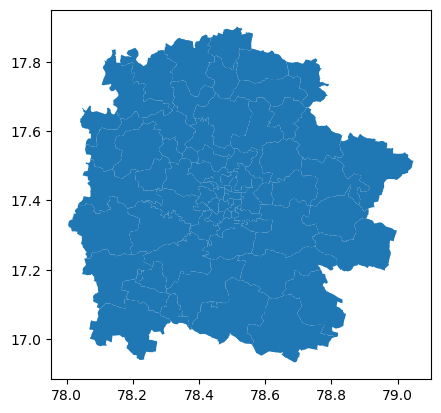

In [19]:
shapefile_path = r'C:\Users\rishi\ml_projects\climate\hmda_boundary\hmda_boundary.shp'
gdf = gpd.read_file(shapefile_path)
gdf.plot()

In [20]:
gdf_points = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df['LON'], df['LAT']),
    crs="EPSG:4326"  # Set the coordinate reference system (WGS84)
)

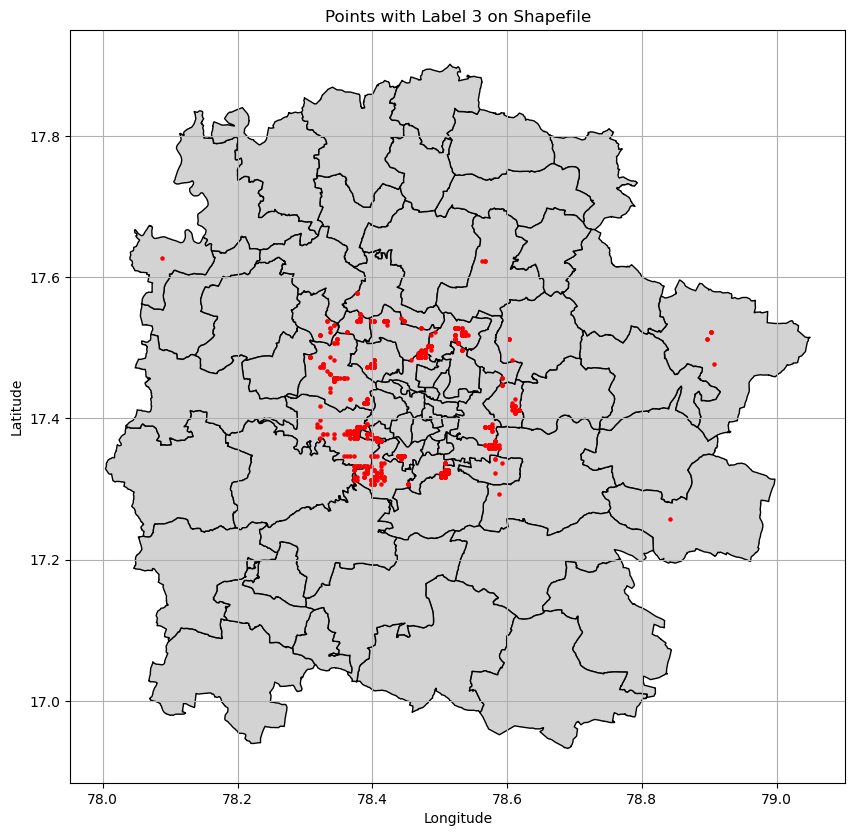

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the shapefile (base map)
gdf.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot the points on top of the shapefile
gdf_points.plot(ax=ax, color='red', markersize=5)

# Customize plot
plt.title("Points with Label 3 on Shapefile")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# Show plot
plt.show()